In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [17]:
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import h5py
from matplotlib.colors import LogNorm
from multiprocessing import Pool
import pystan
import scipy.integrate as si
from scipy.interpolate import interp1d
import seaborn as sns
import sys

p = '/Users/farr/Documents/Research/CBCPopulation/O2Population/code'
try:
    sys.path.index(p)
except ValueError:
    sys.path.append(p)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Our population is going to have $5 \, M_\odot \leq m \leq 40 \, M_\odot$, and we can guarantee that there will be no systems detected with $z > 1$:

In [7]:
vt.fraction_above_threshold(40, 40, 1, 8, psd_fn=vt.ls.SimNoisePSDAdVDesignSensitivityP1200087)

0.0

Let's draw a synthetic population of sources.

In [8]:
def mc_eta_from_m1_m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    
    mc = mt*eta**(3.0/5.0)
    
    return (mc, eta)

48314 mergers per year out to redshift 1


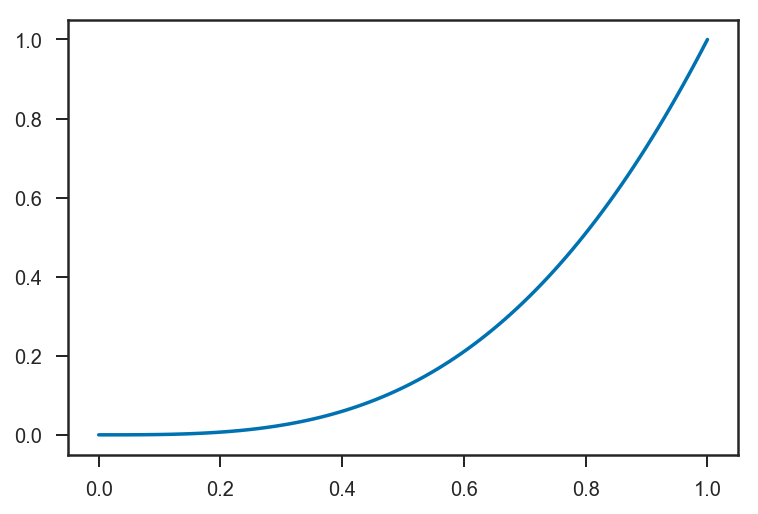

In [9]:
zs = linspace(0, 1, 100)
dNdz = 4.0*pi*100.0*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**2
ngen = int(round(trapz(dNdz, zs)))

print('{:g} mergers per year out to redshift 1'.format(ngen))

dNdz /= trapz(dNdz, zs)

zcum = si.cumtrapz(dNdz, zs, initial=0)
plot(zs, zcum)

zinterp = interp1d(zcum, zs)

We will generate one year of mergers at design sensitivity (out to redshift 1, which is the detection horizon for our most massive black holes).  The mass distribution will be
$$
p\left( m_1, m_2 \right) \propto \frac{m_1^{-1}}{m_1 - M_\mathrm{min}}
$$
(flat in log $m_1$ and flat in $q$) and the rate will be 
$$
\frac{\mathrm{d} N}{\mathrm{d} V_C \mathrm{d} t} = 100 \, \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1} \left( 1 + z \right)^3
$$
in the comoving frame, or an observed merger density of 
$$
\frac{\mathrm{d} N}{\mathrm{d} z} = 100 \, \mathrm{Gpc}^{-3} \frac{\mathrm{d} V_C}{\mathrm{d} z} \left( 1 + z \right)^2.
$$

In [12]:
rstate = random.get_state()
random.seed(752812)

try:
    MMin = 5
    MMax = 40

    m1s = []
    m2s = []
    zs = []
    dls = []

    mc_obs = []
    eta_obs = []
    dl_obs = []
    
    sigma_mc = []
    sigma_eta = []
    sigma_dl = []

    for i in range(ngen):
        m1 = exp(log(MMin) + log(MMax/MMin)*rand())
        m2 = random.uniform(low=MMin, high=m1)
        z = zinterp(rand())

        opt_snr = vt.optimal_snr(m1, m2, z, psd_fn=vt.ls.SimNoisePSDAdVDesignSensitivityP1200087)
        snr = opt_snr*random.choice(vt.thetas)

        if snr > 8:        
            dl = Planck15.luminosity_distance(z).to(u.Gpc).value

            m1s.append(m1)
            m2s.append(m2)
            zs.append(z)
            dls.append(dl)

            mc, eta = mc_eta_from_m1_m2(m1, m2)

            sm = 8/snr*0.03
            se = 8/snr*0.03
            sd = 8/snr*0.3

            dlo = random.lognormal(mean=log(dl), sigma=sd)
            mco = random.lognormal(mean=log(mc*(1+z)), sigma=sm)
            etao = 1
            while etao < 0 or etao > 0.25:
                etao = eta + se*randn()

            mc_obs.append(mco)
            eta_obs.append(etao)
            dl_obs.append(dlo)
            
            sigma_mc.append(sm)
            sigma_eta.append(se)
            sigma_dl.append(sd)
finally:
    random.set_state(rstate)

It takes a while to generate so many systems, so let's save them to disk.

In [13]:
with h5py.File('observations.h5', 'w') as out:
    tg = out.create_group('truth')
    for n, d in (('m1', m1s), ('m2', m2s), ('z', zs), ('dl', dls)):
        tg.create_dataset(n, data=array(d), compression='gzip', shuffle=True)
    
    og = out.create_group('observations')
    for n, d in (('mc', mc_obs), ('eta', eta_obs), ('dl', dl_obs), ('sigma_mc', sigma_mc), ('sigma_eta', sigma_eta), ('sigma_dl', sigma_dl)):
        og.create_dataset(n, data=array(d), compression='gzip', shuffle=True)

Executing the code below will re-load the generated observations:

In [14]:
MMin = 5
MMax = 40

with h5py.File('observations.h5', 'r') as inp:
    m1s = array(inp['truth']['m1'])
    m2s = array(inp['truth']['m2'])
    zs = array(inp['truth']['z'])
    dls = array(inp['truth']['dl'])
    
    mc_obs = array(inp['observations']['mc'])
    eta_obs = array(inp['observations']['eta'])
    dl_obs = array(inp['observations']['dl'])
    sigma_mc = array(inp['observations']['sigma_mc'])
    sigma_eta = array(inp['observations']['sigma_eta'])
    sigma_dl = array(inp['observations']['sigma_dl'])

Can we see the right behaviour in the maximum (or minimum?) mass?  Below is plotted the observed $\mathcal{M}$ and $d_L$ (with errobars) for the hypothetical catalog.  The solid line is the upper-limit on the detector-frame chirp mass derived from the upper limit on mass as a function of $d_L$; the dashed lines are the same, but with a 10% change in the Hubble constant.  Certainly from this plot we could imagine doing some sort of fit to the UL of the mass versus $d_L$; let's try it.

Text(0,0.5,'$\\mathcal{M}$ ($M_\\odot$)')

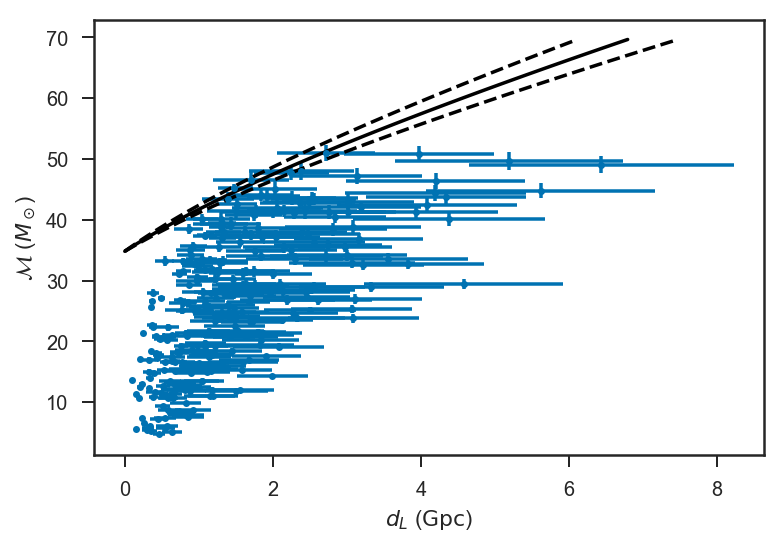

In [15]:
errorbar(dl_obs, mc_obs, xerr=array(dl_obs)*array(sigma_dl), yerr=array(mc_obs)*array(sigma_mc), fmt='.')

z = linspace(0, 1, 100)

plot(Planck15.luminosity_distance(z).to(u.Gpc).value, 2*MMax*(1+array(z))*0.25**(3.0/5.0), '-k')
plot(Planck15.luminosity_distance(z).to(u.Gpc).value*1.1, 2*MMax*(1+array(z))*0.25**(3.0/5.0), '--k')
plot(Planck15.luminosity_distance(z).to(u.Gpc).value*0.9, 2*MMax*(1+array(z))*0.25**(3.0/5.0), '--k')

xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
ylabel(r'$\mathcal{M}$ ($M_\odot$)')

The simplest thing we could do is just to treat this as a (slightly modified) non-linear regression problem.  Each event has a redshift (which is related to $d_L$, i.e. the $x$ coordinate) and a chirp mass (which, for simplicity, we can assume uniformly distributed between zero and $\mathcal{M}_\mathrm{max} \left(1+z\right)$) and we want to fit for them in addition to the cosmological parameters that give us $z\left(d_L\right)$ that matches the maximum chirp mass.

This procedure will almost inevitably be biased because

* It does not model the population in redshift (either physical evolution or selection effects), so had a biased view of how much it *should* be learning at each redshift about the maximum mass.

* It does not model the population in chirp mass, but rather expects the distribution to be flat.  This will give us an artificially tight constraint on the maximum chirp mass if the population is downward sloping in mass (as it is), since it will try to "use" the fact that there are a lot of low-mass objects to argue that we have sampled the high-mass cutoff very well.  (In the limit that the population goes to zero smoothly at the upper cutoff, you transition from $\sigma \sim 1/N$ to $\sigma \sim 1/\sqrt{N}$; but even if the transition is sharp, if the density is much smaller near the upper cutoff the certainty on the location will be smaller even with lots of lower-mass events.)

* It only uses the chirp mass, which tends to "blur" out the sharp $m_1$ cutoff because it mixes with the (in this model, unobserved) $m_2$.  

Really, we should probably just model the population, but let's see what we get with this very simple thing.

In [42]:
model = pystan.StanModel(file='PISNLineRegression.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1bbc3dfc515d14ff6b1d89fcae720cdf NOW.


In [43]:
data = {
    'nobs': len(mc_obs),
    'mc_obs': mc_obs,
    'dl_obs': dl_obs,
    'sigma_mc': sigma_mc,
    'sigma_dl': sigma_dl,
    'zmax': 1.0,
    'ninterp': 100
}

In [44]:
fit = model.sampling(data=data)

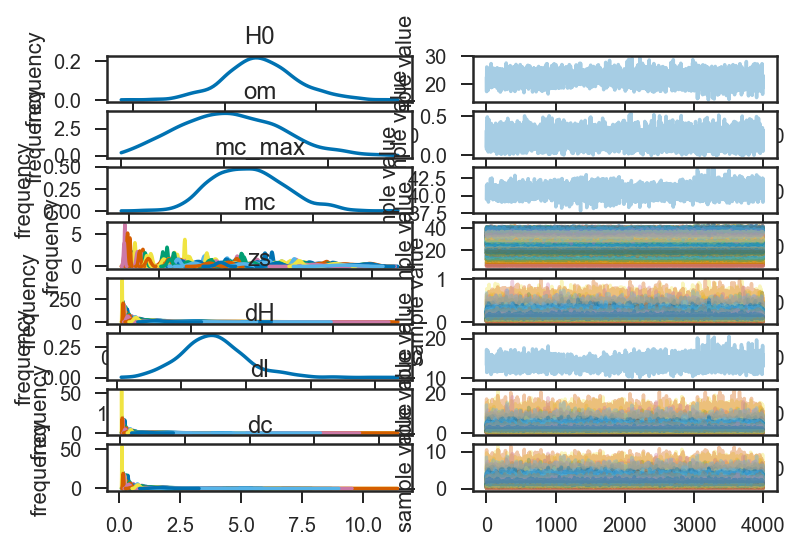

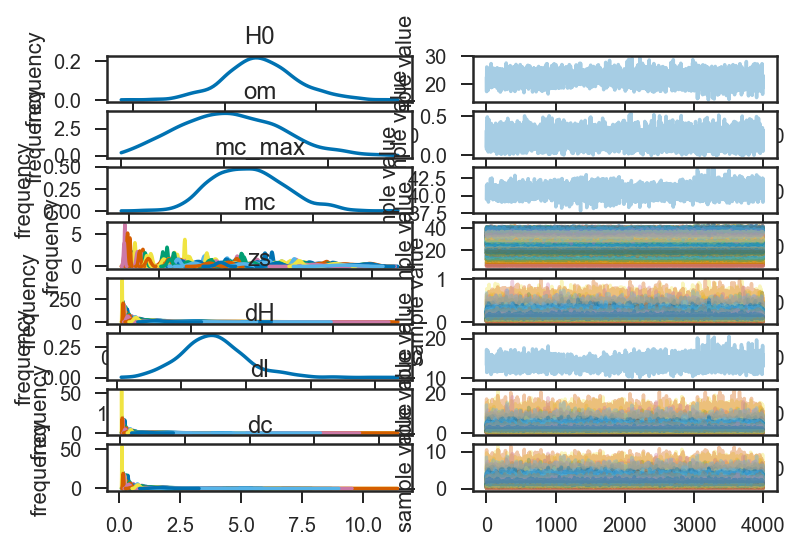

In [45]:
fit.plot()

In [46]:
fit

Inference for Stan model: anon_model_1bbc3dfc515d14ff6b1d89fcae720cdf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0       21.97    0.19   1.99  18.07   20.7   21.9  23.18  26.17  113.0   1.02
om        0.21  1.5e-3    0.1   0.04   0.14   0.21   0.28   0.41 4000.0    1.0
mc_max   40.59     0.1   0.79  39.21  40.01  40.55   41.1   42.3   66.0   1.02
mc[0]    16.92  9.5e-3    0.6  15.73  16.52  16.92  17.34  18.05 4000.0    1.0
mc[1]      6.1  2.8e-3   0.18   5.74   5.98    6.1   6.22   6.44 4000.0    1.0
mc[2]     7.75  2.5e-3   0.16   7.46   7.65   7.75   7.85   8.05 4000.0    1.0
mc[3]    23.83  5.6e-3   0.36  23.14  23.59  23.83  24.07  24.54 4000.0    1.0
mc[4]    30.54  9.7e-3   0.61   29.3  30.13  30.55  30.95  31.71 4000.0    1.0
mc[5]    38.14    0.05   1.38  35.15  37.27  38.23  39.15  40.58  717.0   1.01
mc[6]    27.32  7.9e-

In [47]:
chain = fit.extract(permuted=True)

(0, 12, 1.2069462172474381, 80)

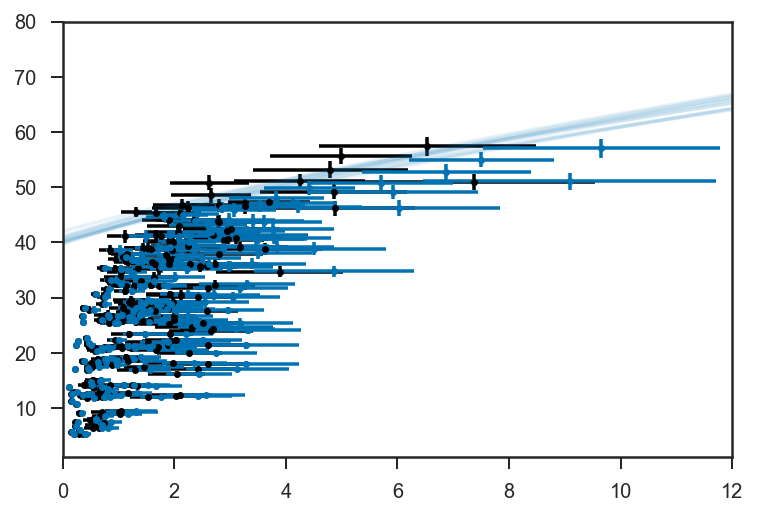

In [58]:
errorbar(dl_obs, mc_obs, xerr=dl_obs*sigma_dl, yerr=mc_obs*sigma_mc, color='k', fmt='.')
errorbar(mean(chain['dl'], axis=0), mean(chain['mc']*(1+chain['zs']), axis=0), xerr=std(chain['dl'], axis=0), yerr=std(chain['mc']*(1+chain['zs']), axis=0), fmt='.', color=sns.color_palette()[0])

z = linspace(0, 1, 100)
for i in randint(chain['dl'].shape[0], size=10):
    c = cosmo.FlatLambdaCDM(chain['H0'][i], chain['om'][i])
    dl = c.luminosity_distance(z).to(u.Gpc).value
    plot(dl, chain['mc_max'][i]*(1+z), alpha=0.1, color=sns.color_palette()[0])
    
axis(xmin=0, xmax=12, ymax=80)

As can be seen above, the failure to model the population (at least in redshift, where there are large uncertainties) causes significant biases in the estimated cosmological parameters (in addition to giving a visually bad fit).  The above plot was produced with a uniform-in-comoving-volume prior, but a flat-in-redshift prior gives a bias in almost the "opposite" direction.  We really need something that adapts to the population that we see.

Since the typical chirp mass uncertainties are pretty small, let's ignore the population prior in the chirp mass (it won't have much effect anyway, since the parameter is pretty well-measured).  We will insert a flexible prior on the population as a function of redshift.  First, the true population in redshift:

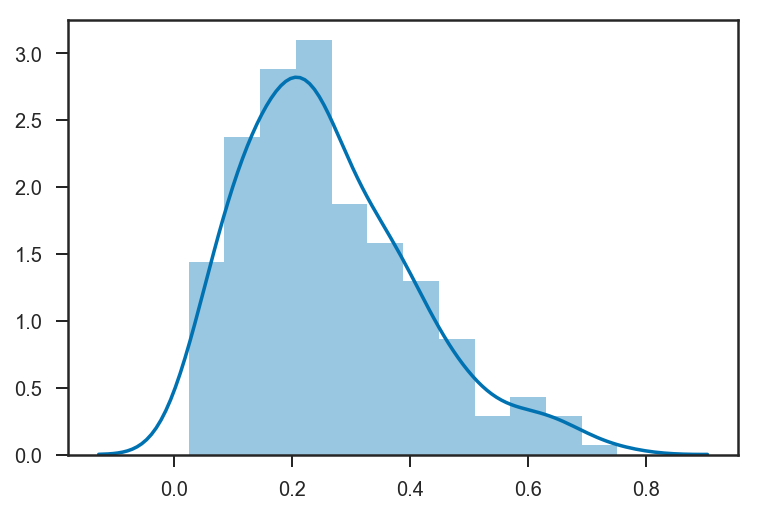

In [59]:
sns.distplot(zs)

Let's just introduce (say) 10 redshift bins, between 0 and 1, and interpolate $\mathrm{d} N / \mathrm{d} z$ on them linearly (we already have linear interpolation code because we solve the cosmology that way).  The modified model is in ``PISNLinePopulationRegression.stan``:

In [70]:
model_pop = pystan.StanModel(file='PISNLinePopulationRegression.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99cc52276f9ec329b02a1b77080a9fa3 NOW.


In [96]:
fit_pop = model_pop.sampling(data=data, iter=4000, thin=2)

In [97]:
fit_pop

Inference for Stan model: anon_model_99cc52276f9ec329b02a1b77080a9fa3.
4 chains, each with iter=4000; warmup=2000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0       93.46    0.67   9.07  78.02  87.05   92.5  99.14 112.71  181.0   1.02
om        0.38  1.8e-3   0.09    0.2   0.32   0.38   0.44   0.56 2391.0    1.0
mc_max   31.44    0.08   0.93   29.7  30.79  31.45  32.08  33.23  134.0   1.03
mc[0]    14.17    0.03   0.93  12.24  13.55  14.27  14.85  15.76 1185.0    1.0
mc[1]     5.38  6.7e-3   0.25   4.88   5.21   5.38   5.55   5.85 1362.0    1.0
mc[2]     6.97  7.2e-3   0.22   6.55   6.82   6.98   7.12   7.37  895.0   1.01
mc[3]    20.31    0.03   0.61  19.08  19.91  20.34  20.73  21.41  455.0   1.01
mc[4]    26.07    0.04   0.97  24.13  25.45   26.1  26.73  27.89  606.0   1.01
mc[5]    29.49    0.08   1.49  26.32  28.56  29.63  30.57  32.06  388.0   1.01
mc[6]    23.98    0.0

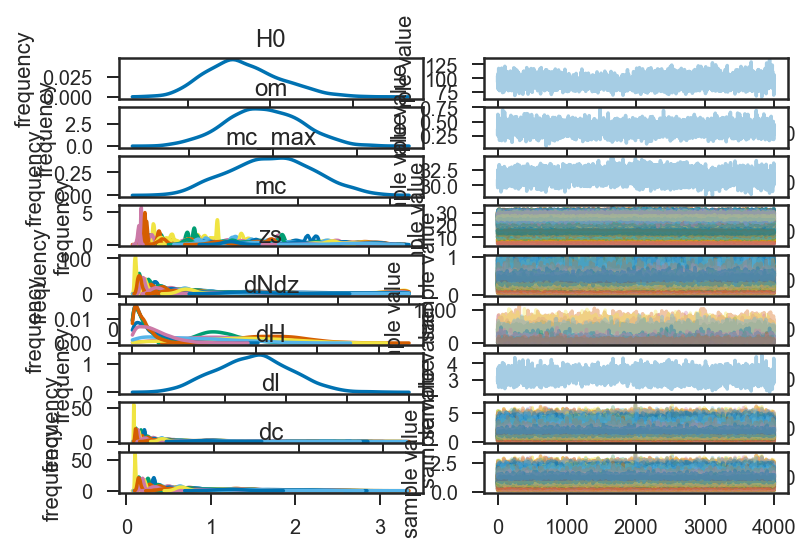

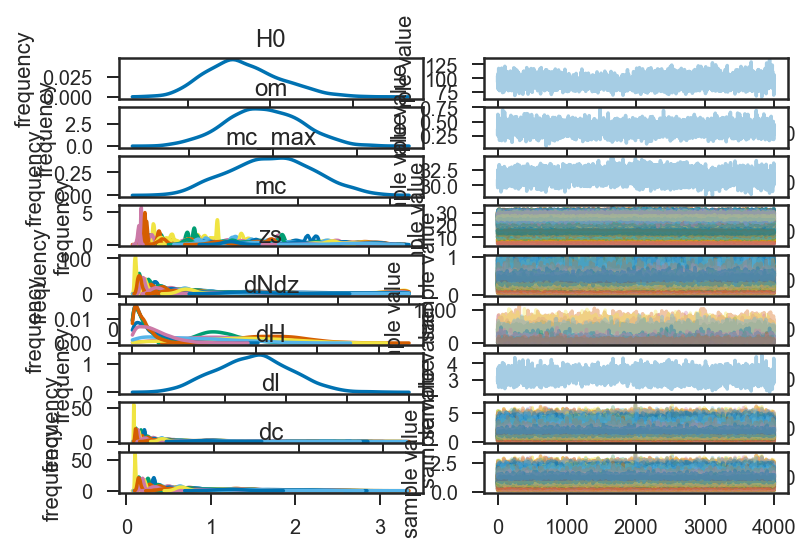

In [98]:
fit_pop.plot()

In [99]:
chain_pop = fit_pop.extract(permuted=True)

Unfortunately, the results are still biased!  You can see that in the plot below.  Incidentally, the newly-recovered distances are much more accurate than the original distances, at least at large $d_L$, where the prior makes a difference.

(0, 12, 1.912307017704518, 80)

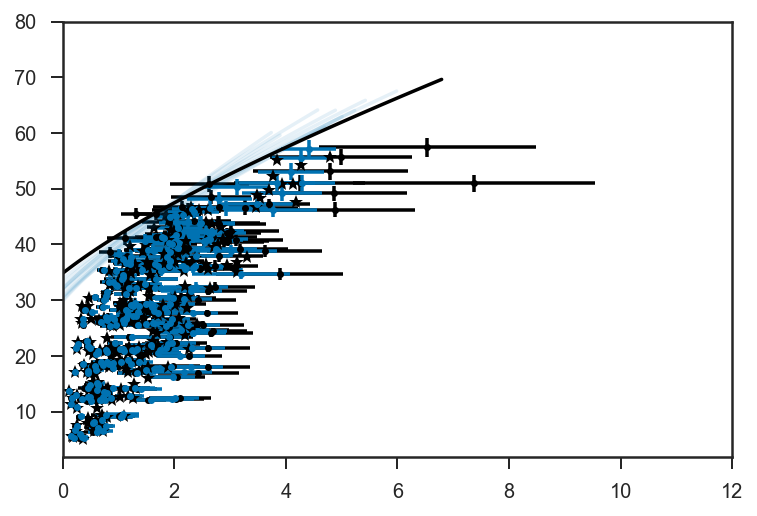

In [106]:
mts = m1s+m2s
etas = m1s*m2s/(mts*mts)
mcs = mts*etas**(3.0/5.0)
plot(dls, mcs*(1+zs), '*', color='k')
errorbar(dl_obs, mc_obs, xerr=dl_obs*sigma_dl, yerr=mc_obs*sigma_mc, color='k', fmt='.')
errorbar(mean(chain_pop['dl'], axis=0), mean(chain_pop['mc']*(1+chain_pop['zs']), axis=0), xerr=std(chain_pop['dl'], axis=0), yerr=std(chain_pop['mc']*(1+chain_pop['zs']), axis=0), fmt='.', color=sns.color_palette()[0])

z = linspace(0, 1, 100)
for i in randint(chain_pop['dl'].shape[0], size=10):
    c = cosmo.FlatLambdaCDM(chain_pop['H0'][i], chain_pop['om'][i])
    dl = c.luminosity_distance(z).to(u.Gpc).value
    plot(dl, chain_pop['mc_max'][i]*(1+z), alpha=0.1, color=sns.color_palette()[0])
    
plot(Planck15.luminosity_distance(z).to(u.Gpc).value, 2*MMax*0.25**(3.0/5.0)*(1+z), color='k')
    
axis(xmin=0, xmax=12, ymax=80)

And more clearly in the distributions of individual parameters here:

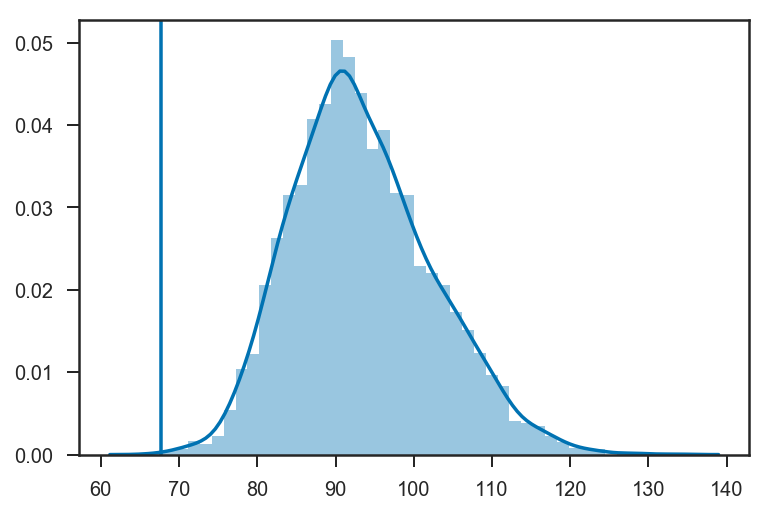

In [103]:
sns.distplot(chain_pop['H0'])
axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value)

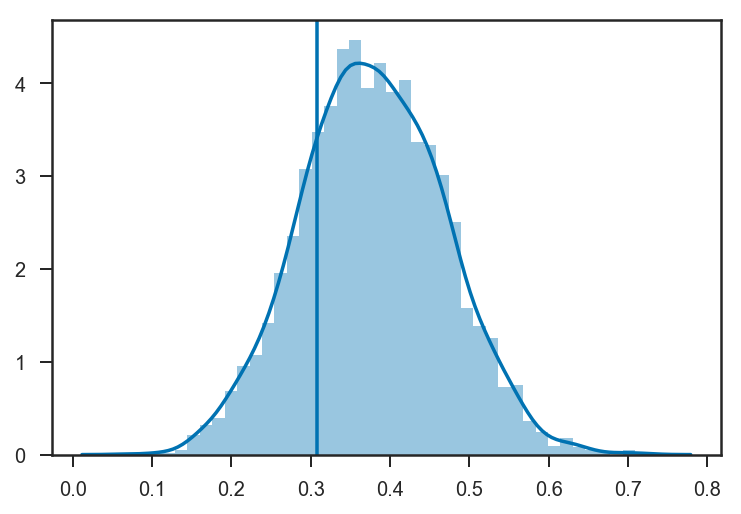

In [104]:
sns.distplot(chain_pop['om'])
axvline(Planck15.Om0)

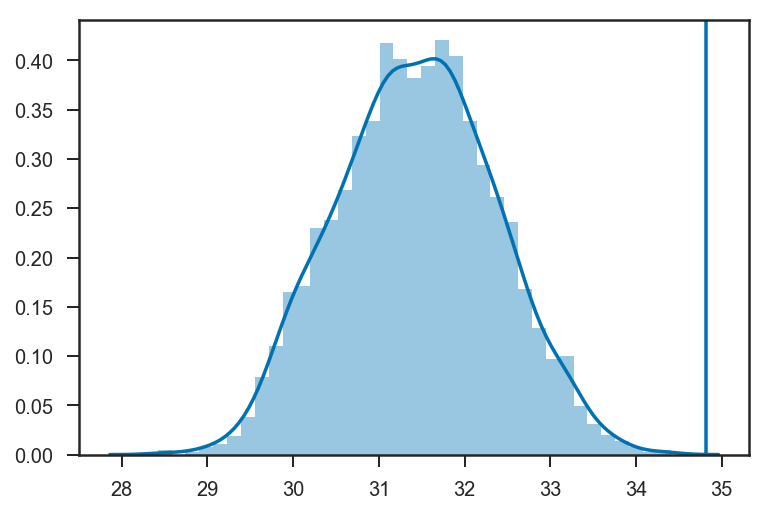

In [105]:
sns.distplot(chain_pop['mc_max'])
axvline(2*MMax*0.25**(3.0/5.0))

I think the likely source of the bias is our assumption of uniformity in the chirp-mass distribution.  Since this implies lots of high-chirp-mass events, we are too confident in assigning the maximum chirp mass to something close to the maximum observed chirp mass, biasing $\mathcal{M}_\mathrm{max}$ low, and therefore $H_0$ high.  I think we need to actually fit the distribution, unfortunately.  In step 1, we create an array containing the optimal SNR as a function of (observed) mass at $d_L = 1\, \mathrm{Gpc}$ (we cannot use redshift directly because we will be adjusting the cosmology).

In [22]:
ms = logspace(log10(3), log10(100), 25)
M1S, M2S = meshgrid(ms, ms, indexing='ij')

def opt_snr(m1m2):
    m1, m2 = m1m2
    z = cosmo.z_at_value(Planck15.luminosity_distance, 1*u.Gpc)
    return vt.optimal_snr(m1/(1+z), m2/(1+z), z, psd_fn=vt.ls.SimNoisePSDAdVDesignSensitivityP1200087)

p = Pool()
try:
    OSNRS = reshape(array(p.map(opt_snr, zip(M1S.ravel(), M2S.ravel()))), M1S.shape)
finally:
    p.close()

Text(0,0.5,'$m_2$ ($M_\\odot$)')

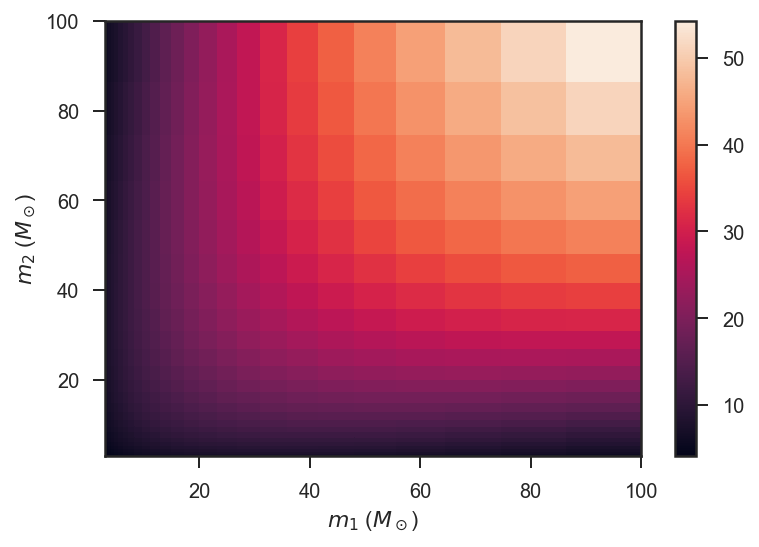

In [23]:
pcolormesh(M1S, M2S, OSNRS)
colorbar()
xlabel(r'$m_1$ ($M_\odot$)')
ylabel(r'$m_2$ ($M_\odot$)')

In [58]:
pop_model = pystan.StanModel(file='PISNLinePopulation.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce3dfb0e7dade531f3de840c3b8e3879 NOW.


In [59]:
thetas = concatenate(([0], sort(vt.thetas), [1]))

In [60]:
pop_data = {
    'nobs': len(mc_obs),
    'mc_obs': mc_obs,
    'eta_obs': eta_obs,
    'dl_obs': dl_obs,
    'sigma_mc': sigma_mc,
    'sigma_eta': sigma_eta,
    'sigma_dl': sigma_dl,
    
    'zmax': 1.0,
    'MMin': 5,
    
    'nms': len(ms),
    'ms': ms,
    'opt_snrs': OSNRS,
    
    'nthetas': len(thetas),
    'thetas': thetas
}

In [61]:
f = pop_model.sampling(data=pop_data, iter=20)

RuntimeError: Initialization failed.